# Background
Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed [data](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) on the number of bicycles people rent by the hour and day.

In this project, I'll try to predict the total number of bikes people rented in a given hour. I'll predict the **`cnt`** column using all of the other columns, except for `casual` and `registered` (they leak information about total number of bikes rented). To accomplish this, I'll create a few different machine learning models and evaluate their performance.

Let's begin by:

1. Using the pandas library to read bike_rental_hour.csv into the dataframe bike_rentals.
2. Printing out the first few rows of bike_rentals and take a look at the data.
3. Making a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.
4. Using the `corr` method on the bike_rentals dataframe to explore how each column is correlated with `cnt`.
5. Displaying the heatmap of correlations using `sns.heatmap()`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bike_rentals= pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


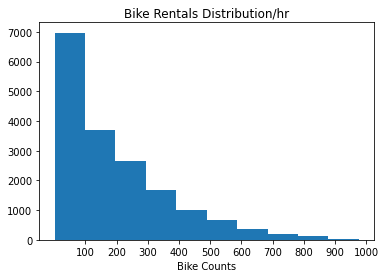

In [3]:
%matplotlib inline
plt.hist(bike_rentals['cnt'])
plt.xlabel('Bike Counts')
plt.title('Bike Rentals Distribution/hr')
plt.xticks([i for i in range(100,1100,100)])
plt.show()

Above histogram shows that number of bikes (target column) that go for rent on any given hour in Washington are more often less than 200.

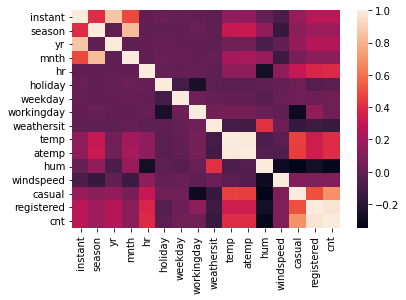

In [4]:
correlations=bike_rentals.corr()
sns.heatmap(correlations)

The above heatmap shows that `cnt` column has some sort of correlation with almost all other columns in our dataset. It also shows that the strongest correlation columns are `casual` and `registered` which we will ignore as they are the subsets of `cnt` column. Using these two columns will give rise to **underfitting (high bias)** as our models will not be informative enough to make predictions on real life situation which involves many variables.

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information or distilling existing information.

For example, the `hr` column in `bike_rentals` contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions. 

Let's write a function called `assign_label` that takes in a numeric value for an hour, and returns:
- 1 if the hour is from 6 to 12
- 2 if the hour is from 12 to 18
- 3 if the hour is from 18 to 24
- 4 if the hour is from 0 to 6

Let's use the apply method on series objects to apply the function to each item in the hr column.
Finally, let's assign the result to the `time_label` column of `bike_rentals`

In [5]:
def assign_label(hour):
    if hour >=6 and hour <12:
        return 1
    elif hour >=12 and hour<18:
        return 2
    elif hour >=18 and hour < 24:
        return 3
    elif hour >=0 and hour <6:
        return 4
    
bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)

Before applying machine learning algorithms, I'll need to split the data into training and testing sets. This will enable me to train an algorithm using the training set, and evaluate its accuracy on the testing set. If I train an algorithm on the training data, then evaluate its performance on the same data, I can get an unrealistically low error value, due to overfitting.

Let's now:

- Select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals. Assign the result to train.
- Select the rows that are in bike_rentals but not in train to be in the testing set. Assign the result to test.
- This line generates a Boolean series that's False when a row in bike_rentals isn't found in train: `bike_rentals.index.isin(train.index)`
- This line selects any rows in bike_rentals that aren't found in train to be in the testing set: `bike_rentals.loc[~bike_rentals.index.isin(train.index)]`

In [6]:
train=bike_rentals.sample(frac=0.8)
len(train)

13903

In [7]:
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)]
len(test)

3476

Now we are ready to try different machine learning algorithms on our training set. At this point it is important to define an error metric to test the accuracy of different models we are going to build. **Given the continuous nature of our target column `cnt`, I will use Root Mean Square Error (RMSE) as the error metric for all my models.**

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# Linear Model

Linear regression works fairly well on this data, given that many of the columns are highly correlated with `cnt`.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

As mentioned before, I need to ignore the `casual` and `registered` columns because `cnt` is derived from them. If I'm trying to predict the number of people who rent bikes in a given hour (`cnt`), it doesn't make sense that I'd already know casual or registered, because those numbers are added together to get cnt.

In [9]:
rmses={}
attributes=train.columns.drop(['cnt','casual',
                               'dteday','registered',
                              ])
target='cnt'

model=LinearRegression()
model.fit(train[attributes],train[target])
predictions=model.predict(test[attributes])
mse=mean_squared_error(test[target],predictions)
print(mse**(1/2),'test rmse')

predictions_train= model.predict(train[attributes])
mse_train=mean_squared_error(train[target],predictions_train)
print(mse_train**(1/2),'train rmse')

rmses['Linear Model']=[mse**(1/2),mse_train**(1/2)]

132.1435838227575 test rmse
132.21645316606612 train rmse


The results here confirm above mentioned observations:

- Linear model seems to underfit as RMSE value is very high
- Linear model appears less greedy as difference between RMSE train and RMSE test is very little

# Simple Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [10]:
model= DecisionTreeRegressor(min_samples_leaf=5)
model.fit(train[attributes],train[target])
predictions=model.predict(test[attributes])
mse=mean_squared_error(test[target],predictions)
print(mse**(1/2),'rmse test')

predictions_train=model.predict(train[attributes])
mse_train=mean_squared_error(train[target],predictions_train)
print(mse_train**(1/2),'rmse train')
rmses['Simple Decision Tree']=[mse**(1/2),mse_train**(1/2)]

51.5879584992927 rmse test
31.899369690766203 rmse train


As noted above, the decision tree algorithm:
- Performs better than simple linear model due to its ability to cater non-linearity in attributes
- Tends to overfit as RMSE train is significantly lower than RMSE test

# Ensembled Decision Tree/ Random Forest

Now let's apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed(ensembling different trees and picking best of everyone), they tend to overfit much less than decision trees. Random forests nonetheless are prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [11]:
model= RandomForestRegressor(n_estimators=100,min_samples_leaf=3)
model.fit(train[attributes],train[target])
predictions= model.predict(test[attributes])
mse=mean_squared_error(test[target],predictions)
print(mse**(1/2),'rmse test')

predictions_train= model.predict(train[attributes])
mse_train= mean_squared_error(train[target],predictions_train)
print(mse_train**(1/2), 'rmse train')
rmses['Ensembled Decision Tree']=[mse**(1/2),mse_train**(1/2)]

41.19472747436689 rmse test
25.646713316143668 rmse train


The results of random forest algorithm show that it perfroms the best on new data even though it is overfitting. 

# Visualizing the Performance of 3 Models

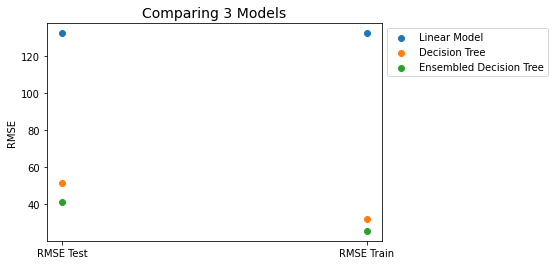

In [12]:
rmses=pd.DataFrame(rmses)
rmses['Metric']=['RMSE Test','RMSE Train']
rmses
plt.figure(figsize=(6,4))
plt.scatter(rmses['Metric'],rmses['Linear Model'],label='Linear Model')
plt.scatter(rmses['Metric'],rmses['Simple Decision Tree'],label='Decision Tree')
plt.scatter(rmses['Metric'],rmses['Ensembled Decision Tree'],label='Ensembled Decision Tree')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1,1))
plt.title('Comparing 3 Models',size=14)
plt.show()


The scatterplot above shows that:
- Linear model overfits the least and is least accurate
- Decision tree overfits the most and is somewhat accurate
- Random forest somewhat overfits and is most accurate

# Visualizing the Best Model

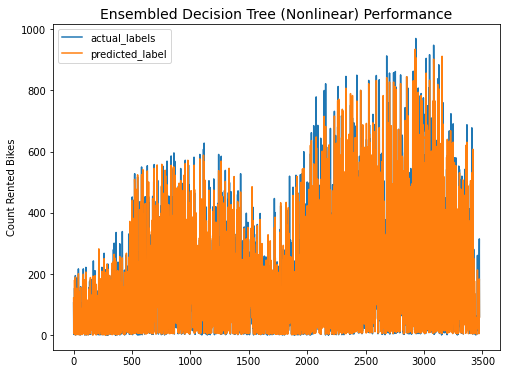

In [13]:
plt.figure(figsize=(8,6))
plt.plot([i for i in range(len(test))],test[target],label='actual_labels')
plt.plot([i for i in range(len(test))],predictions,label='predicted_label')
plt.ylabel('Count Rented Bikes')
plt.legend()
plt.title("Ensembled Decision Tree (Nonlinear) Performance",size=14)
plt.show()